In [37]:
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Setting Device and Loading the Dataset** 

In [38]:

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

NUM_CLASSES = 10
data_path = '../data_cifar/'

# Hyperparameters
random_seed = 1
learning_rate = 0.0001
num_epochs = 10
batch_size = 32

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(data_path,
                                 train=True,
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(data_path,
                                train=False,
                                transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Files already downloaded and verified
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


## **Loading and Modifying the VGG16 Model**

In [39]:
model = models.vgg16(pretrained=True).to(DEVICE)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
# freeze the layers
for param in model.parameters():
    param.requires_grad = False

In [41]:
# activate a random fully connected layer
model.classifier[3].requires_grad = True

In [42]:
# modifying the number of units of the chosen layer
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5), # used to stop overfitting
                      nn.Linear(512, NUM_CLASSES))

In [43]:
model = model.to(DEVICE)
# update the weights using optimizer
optimizer = torch.optim.Adam(model.parameters())

## **Training and testing the model**

In [44]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

train_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
test_stats = {
    'epoch': [],
    'loss': [],
    'acc': []
}
pbar = tqdm(range(num_epochs))
start_time = time.time()
for epoch in (pbar):

    pbar.set_description(f"Epoch {epoch + 1} / 10")
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets)
        acc = accuracy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        train_stats['epoch'].append(epoch + batch_idx / len(train_loader))
        train_stats['loss'].append(cost.item())
        train_stats['acc'].append(acc.item())
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f | Accuracy: %.5f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), cost, acc))

    test_loss = compute_epoch_loss(model, test_loader)
    test_acc = compute_accuracy(model, test_loader)
    test_stats['epoch'].append(epoch + 1)
    test_stats['loss'].append(test_loss)
    test_stats['acc'].append(test_acc)
    print ('Epoch: ', epoch+1, ' Loss = ', test_loss, ' Accuracy = ', test_acc)

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs,
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001/010 | Batch 0000/1563 | Cost: 2.3551 | Accuracy: 0.09375
Epoch: 001/010 | Batch 0050/1563 | Cost: 0.6801 | Accuracy: 0.75000
Epoch: 001/010 | Batch 0100/1563 | Cost: 0.9359 | Accuracy: 0.56250
Epoch: 001/010 | Batch 0150/1563 | Cost: 0.8772 | Accuracy: 0.75000
Epoch: 001/010 | Batch 0200/1563 | Cost: 0.6734 | Accuracy: 0.71875
Epoch: 001/010 | Batch 0250/1563 | Cost: 0.5337 | Accuracy: 0.75000
Epoch: 001/010 | Batch 0300/1563 | Cost: 0.8054 | Accuracy: 0.68750
Epoch: 001/010 | Batch 0350/1563 | Cost: 1.1285 | Accuracy: 0.62500
Epoch: 001/010 | Batch 0400/1563 | Cost: 0.8701 | Accuracy: 0.65625
Epoch: 001/010 | Batch 0450/1563 | Cost: 0.9164 | Accuracy: 0.71875
Epoch: 001/010 | Batch 0500/1563 | Cost: 0.7726 | Accuracy: 0.78125
Epoch: 001/010 | Batch 0550/1563 | Cost: 0.7796 | Accuracy: 0.71875
Epoch: 001/010 | Batch 0600/1563 | Cost: 0.5896 | Accuracy: 0.84375
Epoch: 001/010 | Batch 0650/1563 | Cost: 0.8793 | Accuracy: 0.65625
Epoch: 001/010 | Batch 0700/1563 | Cost: 0.5355 

## **Results and Analysis**

In [58]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 83.23%


In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

In [47]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)



In [48]:
model_out_path = "model.pth"
torch.save(model, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


In [49]:
# function to unnormalize the image 
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

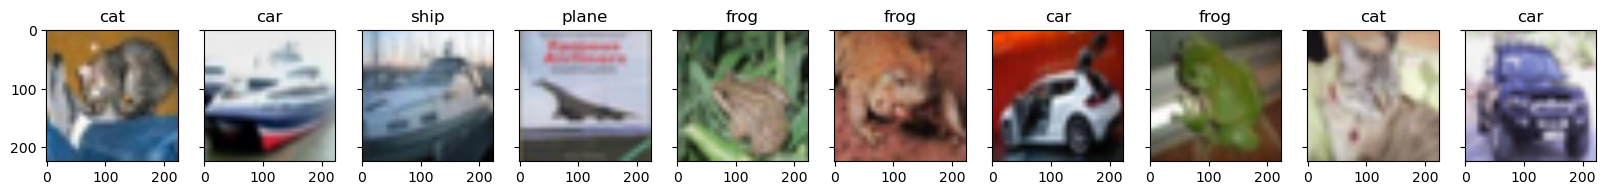

In [50]:
# plots the test images with its predicted labels
n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225])) 
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])

### Confusion Matrix

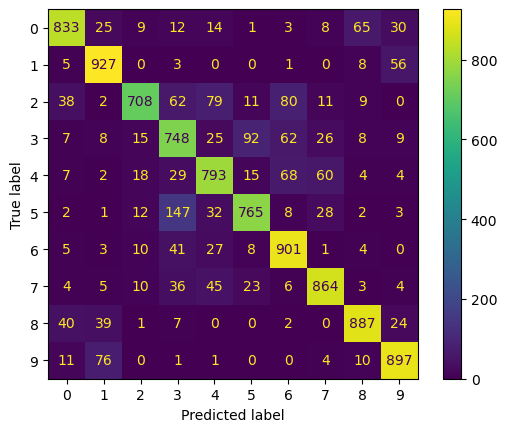

In [60]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():

  for inputs, labels in test_loader:
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
        #   inputs = inputs.reshape(inputs.shape[0], -1)

          output = model(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth


cm = confusion_matrix(y_true,y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

### Classification Report

In [61]:

report = classification_report(y_true,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1000
           1       0.85      0.93      0.89      1000
           2       0.90      0.71      0.79      1000
           3       0.69      0.75      0.72      1000
           4       0.78      0.79      0.79      1000
           5       0.84      0.77      0.80      1000
           6       0.80      0.90      0.85      1000
           7       0.86      0.86      0.86      1000
           8       0.89      0.89      0.89      1000
           9       0.87      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



It was observed that the VGG16 pretrained model gives the significantly higher accuracy comparing with other ANN Models with time elapsed nearly = 77 mins